<a href="https://colab.research.google.com/github/Daniel120622/Final-Year-Project/blob/main/Final_Version_FYP_20241102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inpaint && AutoMask



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install diffusers==0.14.0 xformers transformers scipy ftfy accelerate controlnet_aux peft
!pip install mediapipe
! git clone https://github.com/mikonvergence/ControlNetInpaint
! pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!wget -O selfie_mutliclass_256x256.tflite -q https://storage.googleapis.com/mediapipe-models/image_segmenter/selfie_multiclass_256x256/float32/latest/selfie_multiclass_256x256.tflite

model_path = '/content/selfie_mutliclass_256x256.tflite'

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.

In [ ]:
#Import mediapipe
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import mediapipe as mp
import torch
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow

#Import impaint
import sys
sys.path.append('./ControlNetInpaint/')
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler, DiffusionPipeline
from src.pipeline_stable_diffusion_controlnet_inpaint import *
from diffusers.utils import load_image

from torchvision import datasets, models, transforms
import torch.nn as nn




The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]


This code allows you to upload two PNG files with specific dimensions (either 512x512 or 768x762). Follow these steps to upload the files separately:
1. Run the code below.
2. Upload exactly two PNG files when prompted.


In [ ]:
from google.colab import files
import os

def upload_folder():
    print("Please upload your folder containing two photos (same size = 512x512 ).")
    uploaded = files.upload()

    # Save each uploaded file and get their paths
    file_paths = []
    for filename in uploaded.keys():
        file_path = os.path.join("/content", filename)  # Save in the Colab environment
        with open(file_path, "wb") as f:
            f.write(uploaded[filename])
        file_paths.append(file_path)

    print("Files uploaded successfully.")
    return file_paths

# Upload the images for person and cloth
uploaded_person = upload_folder()
uploaded_cloth = upload_folder()

cloth_image_path = uploaded_cloth[0]  # Assuming the first uploaded file is the cloth image
person_image_path = uploaded_person[0]

# Test with the cloth image path
test_image_path = cloth_image_path
test_image_person_path = person_image_path


Please upload your folder containing two photos (same size = 512x512 ).


Saving Alex_perosn.jpg to Alex_perosn.jpg
Files uploaded successfully.
Please upload your folder containing two photos (same size = 512x512 ).


Saving Oversize-T-shirt (10).jpg to Oversize-T-shirt (10).jpg
Files uploaded successfully.


In [ ]:
class_names = ['Blazer', 'Blouse', 'Body', 'Dress', 'Hat', 'Hoodie', 'Longsleeve',
               'Not sure', 'Other', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes',
               'Shorts', 'Skip', 'Skirt', 'T-Shirt', 'Top', 'Undershirt']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))


model.load_state_dict(torch.load('/content/drive/MyDrive/Final Year Project/model/Final_model.pth'))
model = model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-5-597e19ca6dff>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

def predict_image(model, image_path):
    image = preprocess_image(image_path)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return class_names[preds[0]]


prediction = predict_image(model, test_image_path)
print(f'The predicted class is: {prediction}')

The predicted class is: T-Shirt


In [ ]:
# Function to upload multiple files
from google.colab import userdata
from openai import OpenAI
import os
import cv2

my_secret_key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key= my_secret_key)
assistant = client.beta.assistants.retrieve('asst_EKme21jyA8Tlhi1NcS9CdsjO')

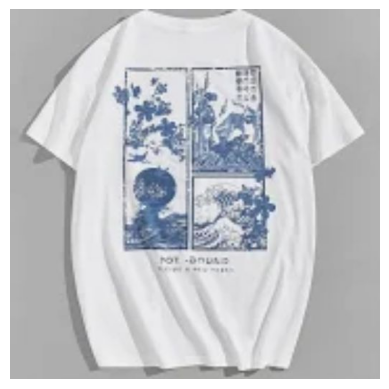

file-5W4JR0bEuf5hu9ViD6VVh2W6


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Upload the file to the client
file = client.files.create(
    file=open(uploaded_cloth[0], "rb"),
    purpose="vision"
)

# Open and display the image locally
with open(uploaded_cloth[0], "rb") as img_file:
    img = Image.open(img_file)
    img.show()  # Opens the image in the default image viewer

# Alternatively, display the image inline (for Jupyter notebooks)
plt.imshow(img)
plt.axis("off")  # Hide axes for a cleaner display
plt.show()

print(file.id)

In [ ]:
# Function to create a new thread and send a user message
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": [{
          "type": "text",
          "text": "Please provide a positive prompt, negative prompt for stable diffusion to generate a similar picture in stable diffusion."
      },
      {
          "type": "image_file",
          "image_file": {"file_id": file.id}
      },
      ]
    }
  ]
)


In [ ]:
from typing_extensions import override
from openai import AssistantEventHandler

# First, we create a EventHandler class to define
# how we want to handle the events in the response stream.



class EventHandler(AssistantEventHandler):
  @override
  def on_text_created(self, text) -> None:
    print(f"\nassistant > ", end="", flush=True)

  @override
  def on_text_delta(self, delta, snapshot):
    print(delta.value, end="", flush=True)

  def on_tool_call_created(self, tool_call):
    print(f"\nassistant > {tool_call.type}\n", flush=True)

  def on_tool_call_delta(self, delta, snapshot):
    if delta.type == 'code_interpreter':
      if delta.code_interpreter.input:
        print(delta.code_interpreter.input, end="", flush=True)
      if delta.code_interpreter.outputs:
        print(f"\n\noutput >", flush=True)
        for output in delta.code_interpreter.outputs:
          if output.type == "logs":
            print(f"\n{output.logs}", flush=True)

# Then, we use the `stream` SDK helper
# with the `EventHandler` class to create the Run
# and stream the response.

with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=assistant.id,
  event_handler=EventHandler(),
) as stream:
  stream.until_done()


assistant > file_search


assistant > **Suggested Response**:
- **Positive Prompt**: T-shirt design featuring a blue and white floral pattern, intricate graphic design, soft cotton fabric, casual style, high-quality print, modern aesthetic
- **Negative Prompt**: Wrinkles, misalignment, faded colors, low resolution, poor print quality

**Additional Parameters**:
- **Seed**: 123456
- **CFG Scale**: 7
- **Steps to refine output**: 25

In [ ]:
IMAGE_PATH = person_image_path
OUTPUT_PATH = '/content/masked_output.jpg'  # Path to save the output image
BG_COLOR = (0, 0, 0) # gray
CLOTHES_MASK_COLOR = (255, 255, 255) # white

# Create the options for the Multi-class selfie segmentation model
base_options = python.BaseOptions(model_asset_path='selfie_mutliclass_256x256.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

        image = mp.Image.create_from_file(IMAGE_PATH)

        # Retrieve the masks for the segmented image
        segmentation_result = segmenter.segment(image)
        category_mask = segmentation_result.category_mask

        # Generate solid color images for showing the output segmentation mask.
        image_data = image.numpy_view()
        fg_image = np.zeros(image_data.shape, dtype=np.uint8)
        fg_image[:] = CLOTHES_MASK_COLOR
        bg_image = np.zeros(image_data.shape, dtype=np.uint8)
        bg_image[:] = BG_COLOR

        # Mask only the clothes category (class 4)
        condition = (category_mask.numpy_view() == 4)
        condition = np.stack((condition,) * 3, axis=-1)  # Expand dimensions for RGB

        # Generate the output image with clothes highlighted
        output_image = np.where(condition, fg_image, bg_image)

        # Display the segmentation result
        print('Segmentation mask of clothes T_shirt')



/usr/local/lib/python3.10/dist-packages/mediapipe/tasks/python/vision/image_segmenter.py:158: UserWarning: MessageFactory class is deprecated. Please use GetMessageClass() instead of MessageFactory.GetPrototype. MessageFactory class will be removed after 2024.
  graph_config = self._runner.get_graph_config()


Segmentation mask of clothes T_shirt


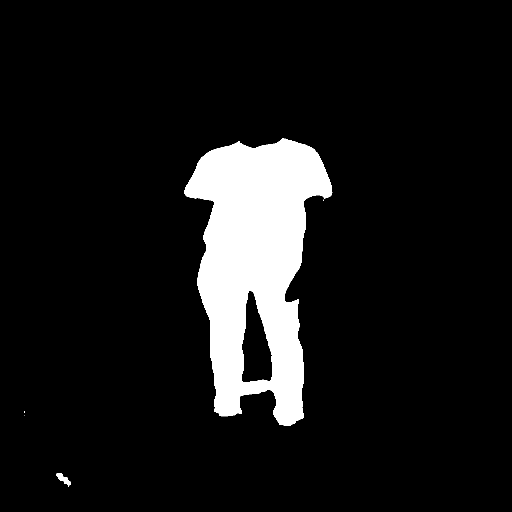

Output image saved at /content/masked_output.jpg


In [ ]:
def resize_and_show(image, output_path, window_name='Segmentation Output'):
    resized_image = cv2.resize(image, (512, 512)) # Resize to a manageable size for display
    cv2_imshow(resized_image)  # Display the image in Colab
    cv2.imwrite(output_path, resized_image)  # Save the image to the specified path
    print(f'Output image saved at {output_path}')
    cv2.waitKey(0)
    cv2.destroyAllWindows()
try:
    resize_and_show(output_image, OUTPUT_PATH)

except:
    !pip uninstall opencv-python
    !pip install opencv-python

finally:
    masked_output = output_image



In [ ]:
from controlnet_aux import OpenposeDetector

controlnet = ControlNetModel.from_pretrained("fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

pipe.to('cuda')
openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

pose_real_image = load_image(person_image_path)

pose_image = openpose(pose_real_image)
pose_real_image=pose_real_image.resize(pose_image.size)

pose_mask=np.zeros_like(np.array(masked_output))
pose_mask=Image.fromarray(masked_output)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/modeling_utils.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

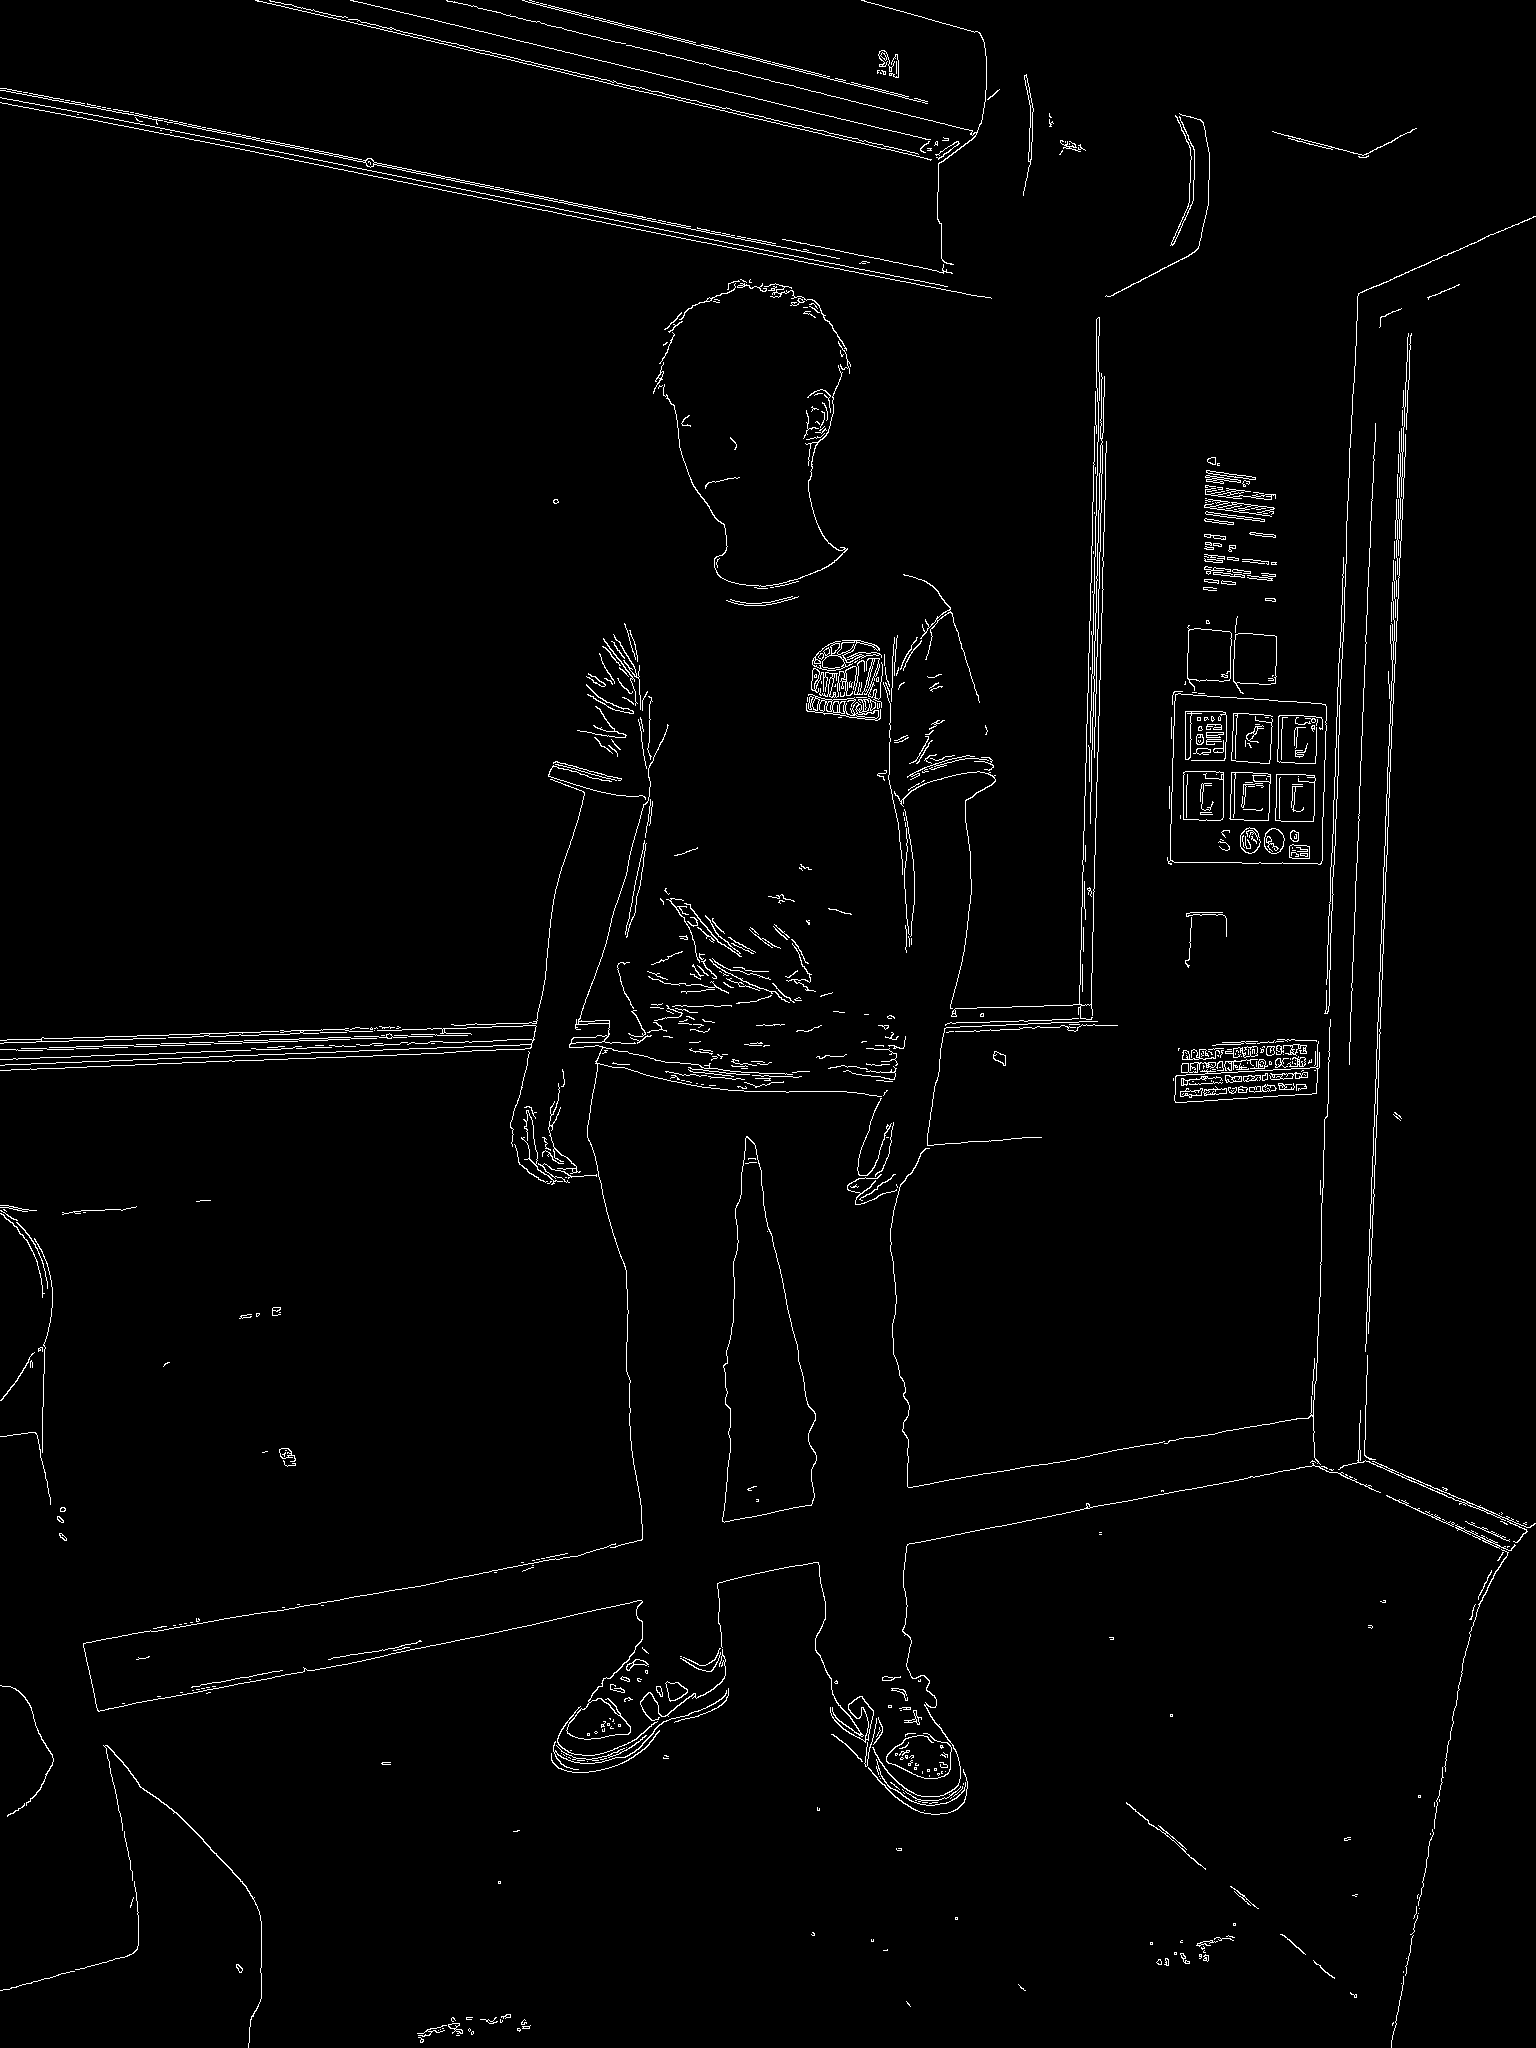

In [ ]:
# load control net and stable diffusion v1-5


image = load_image(person_image_path)

#controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
"""controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16)

#pipe_id = "ruwnayml/stable-diffusion-v1-5"
#pipe = DiffusionPipeline.from_pretrained(pipe_id, controlnet = controlnet ,torch_dtype=torch.float16).to("cuda")
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.to('cuda')


# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
"""

# get canny image
image = np.array(image)
canny_image = cv2.Canny(image, 100, 200)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)

image=Image.fromarray(image)

canny_image = Image.fromarray(canny_image)

canny_image

In [ ]:
generator = torch.manual_seed(123)

new_image = pipe(
    positive_prompt = "T-shirt, dark green, vintage",
    negative_prompt = "Wrinkles, misalignment, faded colors",
    num_inference_steps=20,
    generator=generator,
    image=pose_real_image,
    control_image=pose_image,
    #control_image=canny_image,
    #controlnet_conditioning_scale = 0.5,
    mask_image=pose_mask
).images[0]


new_image

RuntimeError: The size of tensor a (512) must match the size of tensor b (1536) at non-singleton dimension 3

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(pose_real_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(pose_real_image))*(255-np.array(pose_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(pose_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')